In [1]:
!nvidia-smi

Thu Apr  7 09:15:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    35W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
import sys
drive.mount('/content/drive')
#设置路径
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

Mounted at /content/drive


In [3]:
! pip install transformers==4.0.1

     |████████████████████████████████| 1.4 MB 11.9 MB/s 
     |████████████████████████████████| 2.9 MB 30.1 MB/s 
     |████████████████████████████████| 895 kB 44.4 MB/s 


In [4]:
! pip install torch==1.4.0

     |████████████████████████████████| 753.4 MB 6.7 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.4.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.4.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.4.0 which is incompatible.


In [5]:
import torch
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

config = {
    'train_file_path':'/content/drive/MyDrive/Colab Notebooks/dataset/train.csv',
    'test_file_path':'/content/drive/MyDrive/Colab Notebooks/dataset/test.csv',
    'train_val_ratio':0.1,
    'model_path':'/content/drive/MyDrive/Colab Notebooks/dataset/NeZha_model',
    'batch_size':16,
    'head': 'cnn',
    'num_epochs':1,
    'learning_rate':2e-5,
    'logging_step':500,
    'seed':2022
}

config['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

def seed_everything(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  return seed

seed_everything(config['seed'])

2022

## Pandas.DataFrame iterrows()
iterrows() 是在数据框中的行进行迭代的一个生成器，它返回每行的索引及一个包含行本身的对象。

In [6]:
from collections import defaultdict
def read_data(config, tokenizer, mode = 'train'):
  data_df = pd.read_csv(config[f'{mode}_file_path'], sep=',')
  if mode == 'train':
    X_train, y_train = defaultdict(list),[]
    X_val, y_val = defaultdict(list),[]
    num_val = int(len(data_df) * config['train_val_ratio'])
  else:
    X_test, y_test = defaultdict(list),[]

  for i, row in tqdm(data_df.iterrows(), desc=f'preprocess {mode} data', colour = 'blue', total = len(data_df)):
#desc（'str'）: 传入进度条的前缀
    label = row[1] if mode == 'train' else 0
    sentence = row[-1]

    inputs = tokenizer.encode_plus(sentence, add_special_tokens = True, return_token_type_ids = True, return_attention_mask = True)

    if mode == 'train':
      if i < num_val:
        X_val['inputs_ids'].append(inputs['input_ids'])
        y_val.append(label)
        X_val['token_type_ids'].append(inputs['token_type_ids'])
        X_val['attention_mask'].append(inputs['attention_mask'])
      else:
        X_train['inputs_ids'].append(inputs['input_ids'])
        y_train.append(label)
        X_train['token_type_ids'].append(inputs['token_type_ids'])
        X_train['attention_mask'].append(inputs['attention_mask'])

    else:
        X_test['inputs_ids'].append(inputs['input_ids'])
        y_test.append(label)
        X_test['token_type_ids'].append(inputs['token_type_ids'])
        X_test['attention_mask'].append(inputs['attention_mask'])

  if mode == 'train':
    label2id = {label: i for i, label in enumerate(np.unique(y_train))}
    id2label = {i: label for label, i in label2id.items()}

    y_train = torch.tensor([label2id[i] for i in y_train], dtype =torch.long)

    y_val = torch.tensor([label2id[i] for i in y_val], dtype =torch.long)
    return X_train, y_train, X_val, y_val, label2id, id2label

  else:
    y_test = torch.tensor(y_test, dtype = torch.long)
    return X_test, y_test


In [7]:
from torch.utils.data import Dataset
class TNEWSData(Dataset):
  def __init__(self, X, y):
    self.x = X
    self.y = y
  
  #如果在类中定义了__getitem__()方法，那么他的实例对象（假设为P）就可以这样P[key]取值。
  def __getitem__(self, idx):
    return{
        'inputs_ids': self.x['inputs_ids'][idx],
        'label':self.y[idx],
        'token_type_ids':self.x['token_type_ids'][idx],
        'attention_mask':self.x['attention_mask'][idx]

    }

  #__len__()的作用是返回容器中元素的个数，要想使len()函数成功执行，必须要在类中定义__len__()。
  def __len__(self):
    return self.y.size(0)

In [8]:
def collate_fn(example):
  input_ids_list = []
  labels = []
  token_type_ids_list = []
  attention_mask_list = []

  for ex in example:
    input_ids_list.append(ex['inputs_ids'])
    labels.append(ex['label'])
    token_type_ids_list.append(ex['token_type_ids'])
    attention_mask_list.append(ex['attention_mask'])

  max_len = max(len(input_ids) for input_ids in input_ids_list)
  input_ids_tensor = torch.zeros((len(labels), max_len),dtype=torch.long)
  token_type_ids_tensor = torch.zeros_like(input_ids_tensor)
  attention_mask_tensor = torch.zeros_like(input_ids_tensor)

  for i, input_ids in enumerate(input_ids_list):
    input_ids_tensor[i, :len(input_ids)] = torch.tensor(input_ids, dtype = torch.long)
    token_type_ids_tensor[i, :len(input_ids)] = torch.tensor(token_type_ids_list[i], dtype = torch.long)
    attention_mask_tensor[i, :len(input_ids)] = torch.tensor(attention_mask_list[i], dtype = torch.long)

  return {
      'input_ids': input_ids_tensor,
      'labels': torch.tensor(labels ,dtype= torch.long),
      'token_type_ids':token_type_ids_tensor,
      'attention_mask':attention_mask_tensor
  }  

In [9]:
from transformers import BertTokenizer
from torch.utils.data import DataLoader
def build_dataloader(config):
  tokenizer = BertTokenizer.from_pretrained(config['model_path'])
  X_train, y_train, X_val, y_val, label2id, id2label = read_data(config, tokenizer, mode='train')
  X_test, y_test = read_data(config, tokenizer, mode='test')

  train_dataset = TNEWSData(X_train, y_train)
  val_dataset = TNEWSData(X_val, y_val)
  test_dataset = TNEWSData(X_test, y_test)

  train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], num_workers = 4, shuffle = True, collate_fn=collate_fn)
  val_dataloader = DataLoader(val_dataset, batch_size=config['batch_size'], num_workers = 4, shuffle = False, collate_fn=collate_fn)
  test_dataloader = DataLoader(test_dataset, batch_size=config['batch_size'], num_workers = 4, shuffle = False, collate_fn=collate_fn)

  return train_dataloader, val_dataloader, test_dataloader, id2label


In [10]:
train_dataloader, val_dataloader, test_dataloader, id2label = build_dataloader(config)

preprocess test data: 100%|██████████| 10000/10000 [00:05<00:00, 1817.10it/s]


## CLASS torch.nn.Module
## model.train(mode=True)与 model.eval()
train: Sets the module in training mode.

Parameters:

- mode (bool) - whether to set training mode (True) or evaluation mode (False). Default: True.

Returns:
- self

Return type:
- Module

## with
with是python中上下文管理器，简单理解，当要进行固定的进入，返回操作时，可以将对应需要的操作，放在with所需要的语句中。比如文件的写入（需要打开关闭文件）等。

## with torch.no_grad():
在使用pytorch时，并不是所有的操作都需要进行计算图的生成（计算过程的构建，以便梯度反向传播等操作）。而对于tensor的计算操作，默认是要进行计算图的构建的，在这种情况下，可以使用 with torch.no_grad():，强制之后的内容不进行计算图构建。**即被with torch.no_grad()包住的代码，不用跟踪反向梯度计算**

(1)使用with torch.no_grad():
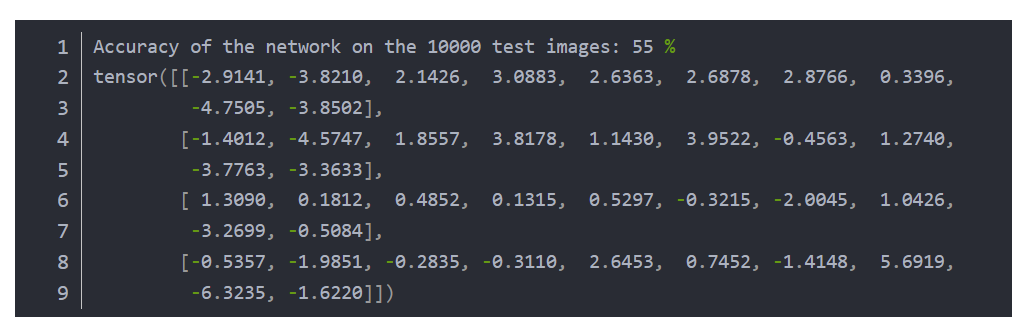

(2）不使用with torch.no_grad():
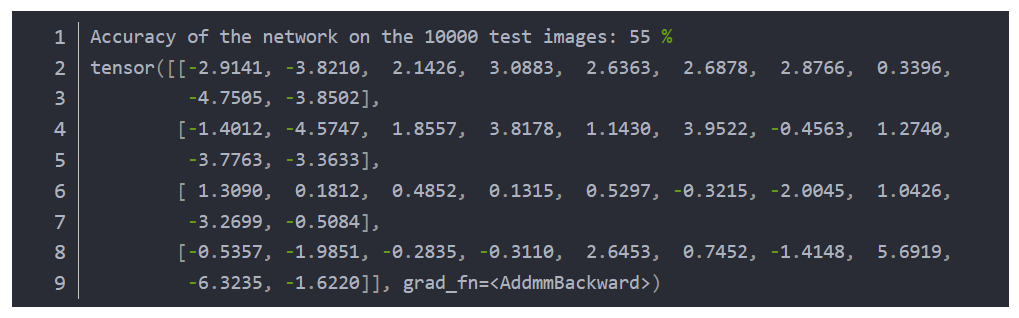

In [11]:
from sklearn.metrics import f1_score
def evaluation(config, model, val_dataloader):
  #model.eval() Sets the module in evaluation mode.
  #Returns:self   Return type: Module
  model.eval()
  preds = []
  labels = []
  val_loss = 0.
  val_iterator = tqdm(val_dataloader, desc='Evaluation', total=len(val_dataloader))

  with torch.no_grad():
    for batch in val_iterator:
      labels.append(batch['labels'])
      batch = {item: value.to(config['device']) for item, value in batch.items()}
      loss, logits = model(**batch)[:2]
      val_loss += loss.item()
      preds.append(logits.argmax(dim = -1).detach().cpu())

  avg_val_loss = val_loss / len(val_dataloader)
  labels = torch.cat(labels, dim = 0).numpy()
  preds = torch.cat(preds, dim = 0).numpy()
  f1 = f1_score(labels, preds, average='macro')
  return avg_val_loss, f1


In [12]:
#NeZha + head
from NeZha import *
class NeZhaForTNEWS(NeZhaPreTrainedModel):
  def __init__(self, config, model_path, classifier):
    super(NeZhaForTNEWS, self).__init__(config)

    self.nezha = NeZhaModel.from_pretrained(model_path, config=config)
    self.classifier = classifier

  def forward(self, input_ids, token_type_ids, attention_mask, labels):
    outputs = self.nezha(input_ids = input_ids,
                token_type_ids = token_type_ids,
                attention_mask = attention_mask)
    hidden_states = outputs[2]

    logits = self.classifier(hidden_states, input_ids)

    outputs = (logits, )

    if labels is not None:
      loss_fct = nn.CrossEntropyLoss()
      loss = loss_fct(logits, labels.view(-1))
      outputs = (loss, )+ outputs

    return outputs

In [13]:
import torch.nn.functional as F
import torch.nn as nn
class ConvClassifier(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.conv = nn.Conv1d(in_channels = config.hidden_size, out_channels = config.hidden_size, kernel_size = 3)
    self.global_max_pool = nn.AdaptiveMaxPool1d(1)
    self.dropout = nn.Dropout(config.hidden_dropout_prob)##隐藏层dropout概率 
    self.fc = nn.Linear(config.hidden_size, config.num_labels)

  def forward(self, hidden_states, input_ids):
    hidden_states = self.dropout(hidden_states[-1])
    hidden_states = hidden_states.permute(0 ,2, 1)

    out = F.relu(self.conv(hidden_states))
    out = self.global_max_pool(out).squeeze(dim=2)
    out = self.fc(out)
    
    return out

In [14]:
def build_model(model_path, config, head):
  heads = {
      'cnn': ConvClassifier
  }
  model = NeZhaForTNEWS(config, model_path, heads[head](config))
  return model

In [15]:
from transformers import BertConfig, BertForSequenceClassification
from transformers import AdamW
from tqdm import trange
def train(config, id2label, train_dataloader, val_dataloader):
  nezha_config = NeZhaConfig.from_pretrained(config['model_path'])
  nezha_config.output_hidden_states = True
  nezha_config.num_labels = len(id2label)

  model = build_model(config['model_path'], nezha_config, config['head'])

  optimizer = AdamW(model.parameters(), lr= config['learning_rate'])

  model.to(config['device'])
  epoch_iterator = trange(config['num_epochs'])
  global_steps = 0
  train_loss = 0.
  logging_loss = 0.

  for epoch in epoch_iterator:
    train_iterator = tqdm(train_dataloader, desc='Training', total=len(train_dataloader))
    model.train()
    for batch in train_iterator:
      batch = {item: value.to(config['device']) for item, value in batch.items()}
      loss = model(**batch)[0]
      model.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss += loss.item()
      global_steps += 1

      if global_steps % config['logging_step'] == 0:
        print_train_loss = (train_loss - logging_loss) / config['logging_step']
        logging_loss = train_loss
        avg_val_loss, f1 = evaluation(config, model, val_dataloader)

        print_log = f'>>>traing loss:{print_train_loss: .5f}, valid loss:{avg_val_loss: .5f}, valid f1 score:{f1: .5f}'
        print(print_log)
        model.train()

  return model    

In [16]:
model = train(config, id2label, train_dataloader, val_dataloader)

Some weights of NeZhaModel were not initialized from the model checkpoint at /content/drive/MyDrive/Colab Notebooks/dataset/NeZha_model and are newly initialized: ['bert.encoder.layer.0.attention.self.relative_positions_encoding.positions_encoding', 'bert.encoder.layer.1.attention.self.relative_positions_encoding.positions_encoding', 'bert.encoder.layer.2.attention.self.relative_positions_encoding.positions_encoding', 'bert.encoder.layer.3.attention.self.relative_positions_encoding.positions_encoding', 'bert.encoder.layer.4.attention.self.relative_positions_encoding.positions_encoding', 'bert.encoder.layer.5.attention.self.relative_positions_encoding.positions_encoding', 'bert.encoder.layer.6.attention.self.relative_positions_encoding.positions_encoding', 'bert.encoder.layer.7.attention.self.relative_positions_encoding.positions_encoding', 'bert.encoder.layer.8.attention.self.relative_positions_encoding.positions_encoding', 'bert.encoder.layer.9.attention.self.relative_positions_encodi

>>>traing loss: 1.75500, valid loss: 1.42656, valid f1 score: 0.50146



Training:  33%|███▎      | 999/3002 [05:20<09:38,  3.46it/s]

Evaluation:   0%|          | 0/334 [00:00<?, ?it/s]

Evaluation:   0%|          | 1/334 [00:00<01:41,  3.28it/s]

Evaluation:   1%|          | 2/334 [00:00<01:01,  5.39it/s]

Evaluation:   1%|          | 3/334 [00:00<00:50,  6.57it/s]

Evaluation:   1%|▏         | 5/334 [00:00<00:36,  8.91it/s]

Evaluation:   2%|▏         | 7/334 [00:00<00:31, 10.45it/s]

Evaluation:   3%|▎         | 9/334 [00:00<00:28, 11.59it/s]

Evaluation:   3%|▎         | 11/334 [00:01<00:28, 11.45it/s]

Evaluation:   4%|▍         | 13/334 [00:01<00:27, 11.71it/s]

Evaluation:   4%|▍         | 15/334 [00:01<00:26, 12.21it/s]

Evaluation:   5%|▌         | 17/334 [00:01<00:26, 12.09it/s]

Evaluation:   6%|▌         | 19/334 [00:01<00:26, 11.95it/s]

Evaluation:   6%|▋         | 21/334 [00:01<00:25, 12.06it/s]

Evaluation:   7%|▋         | 23/334 [00:02<00:26, 11.86it/s]

Evaluation:   7%|▋         | 25/334 [00:02<00:26, 11.79it/s]

Evaluation:   8%|▊    

>>>traing loss: 1.40505, valid loss: 1.34260, valid f1 score: 0.51842



Training:  50%|████▉     | 1499/3002 [08:17<07:29,  3.34it/s]

Evaluation:   0%|          | 0/334 [00:00<?, ?it/s]

Evaluation:   0%|          | 1/334 [00:00<02:25,  2.28it/s]

Evaluation:   1%|          | 3/334 [00:00<00:59,  5.55it/s]

Evaluation:   1%|          | 4/334 [00:00<00:50,  6.55it/s]

Evaluation:   2%|▏         | 6/334 [00:00<00:37,  8.82it/s]

Evaluation:   2%|▏         | 8/334 [00:01<00:32,  9.90it/s]

Evaluation:   3%|▎         | 10/334 [00:01<00:30, 10.66it/s]

Evaluation:   4%|▎         | 12/334 [00:01<00:29, 10.90it/s]

Evaluation:   4%|▍         | 14/334 [00:01<00:28, 11.18it/s]

Evaluation:   5%|▍         | 16/334 [00:01<00:28, 11.31it/s]

Evaluation:   5%|▌         | 18/334 [00:01<00:27, 11.48it/s]

Evaluation:   6%|▌         | 20/334 [00:02<00:27, 11.34it/s]

Evaluation:   7%|▋         | 22/334 [00:02<00:28, 10.89it/s]

Evaluation:   7%|▋         | 24/334 [00:02<00:29, 10.59it/s]

Evaluation:   8%|▊         | 26/334 [00:02<00:30, 10.20it/s]

Evaluation:   8%|▊  

>>>traing loss: 1.31303, valid loss: 1.27179, valid f1 score: 0.54152



Training:  67%|██████▋   | 1999/3002 [11:16<05:05,  3.28it/s]

Evaluation:   0%|          | 0/334 [00:00<?, ?it/s]

Evaluation:   0%|          | 1/334 [00:00<01:43,  3.21it/s]

Evaluation:   1%|          | 2/334 [00:00<01:04,  5.15it/s]

Evaluation:   1%|          | 4/334 [00:00<00:41,  7.92it/s]

Evaluation:   2%|▏         | 6/334 [00:00<00:33,  9.66it/s]

Evaluation:   2%|▏         | 8/334 [00:00<00:29, 10.87it/s]

Evaluation:   3%|▎         | 10/334 [00:01<00:28, 11.23it/s]

Evaluation:   4%|▎         | 12/334 [00:01<00:27, 11.61it/s]

Evaluation:   4%|▍         | 14/334 [00:01<00:27, 11.75it/s]

Evaluation:   5%|▍         | 16/334 [00:01<00:26, 12.11it/s]

Evaluation:   5%|▌         | 18/334 [00:01<00:26, 11.92it/s]

Evaluation:   6%|▌         | 20/334 [00:01<00:26, 12.03it/s]

Evaluation:   7%|▋         | 22/334 [00:02<00:25, 12.14it/s]

Evaluation:   7%|▋         | 24/334 [00:02<00:26, 11.77it/s]

Evaluation:   8%|▊         | 26/334 [00:02<00:26, 11.45it/s]

Evaluation:   8%|▊  

>>>traing loss: 1.26769, valid loss: 1.26144, valid f1 score: 0.51867



Training:  83%|████████▎ | 2499/3002 [14:13<02:24,  3.48it/s]

Evaluation:   0%|          | 0/334 [00:00<?, ?it/s]

Evaluation:   0%|          | 1/334 [00:00<01:47,  3.10it/s]

Evaluation:   1%|          | 2/334 [00:00<01:05,  5.04it/s]

Evaluation:   1%|          | 4/334 [00:00<00:42,  7.75it/s]

Evaluation:   2%|▏         | 6/334 [00:00<00:34,  9.60it/s]

Evaluation:   2%|▏         | 8/334 [00:00<00:29, 10.98it/s]

Evaluation:   3%|▎         | 10/334 [00:01<00:28, 11.47it/s]

Evaluation:   4%|▎         | 12/334 [00:01<00:27, 11.69it/s]

Evaluation:   4%|▍         | 14/334 [00:01<00:26, 11.99it/s]

Evaluation:   5%|▍         | 16/334 [00:01<00:25, 12.37it/s]

Evaluation:   5%|▌         | 18/334 [00:01<00:25, 12.21it/s]

Evaluation:   6%|▌         | 20/334 [00:01<00:25, 12.22it/s]

Evaluation:   7%|▋         | 22/334 [00:02<00:25, 12.06it/s]

Evaluation:   7%|▋         | 24/334 [00:02<00:26, 11.64it/s]

Evaluation:   8%|▊         | 26/334 [00:02<00:27, 11.37it/s]

Evaluation:   8%|▊  

>>>traing loss: 1.25670, valid loss: 1.25831, valid f1 score: 0.53359



Training: 100%|█████████▉| 2999/3002 [17:10<00:00,  3.64it/s]

Evaluation:   0%|          | 0/334 [00:00<?, ?it/s]

Evaluation:   0%|          | 1/334 [00:00<01:37,  3.41it/s]

Evaluation:   1%|          | 2/334 [00:00<00:59,  5.54it/s]

Evaluation:   1%|          | 3/334 [00:00<00:48,  6.84it/s]

Evaluation:   1%|▏         | 5/334 [00:00<00:35,  9.20it/s]

Evaluation:   2%|▏         | 7/334 [00:00<00:30, 10.78it/s]

Evaluation:   3%|▎         | 9/334 [00:00<00:28, 11.48it/s]

Evaluation:   3%|▎         | 11/334 [00:01<00:28, 11.30it/s]

Evaluation:   4%|▍         | 13/334 [00:01<00:28, 11.34it/s]

Evaluation:   4%|▍         | 15/334 [00:01<00:26, 11.97it/s]

Evaluation:   5%|▌         | 17/334 [00:01<00:26, 11.86it/s]

Evaluation:   6%|▌         | 19/334 [00:01<00:26, 11.70it/s]

Evaluation:   6%|▋         | 21/334 [00:01<00:26, 11.94it/s]

Evaluation:   7%|▋         | 23/334 [00:02<00:26, 11.62it/s]

Evaluation:   7%|▋         | 25/334 [00:02<00:26, 11.73it/s]

Evaluation:   8%|▊   

>>>traing loss: 1.22285, valid loss: 1.27639, valid f1 score: 0.53340



100%|██████████| 1/1 [17:41<00:00, 1061.36s/it]


In [31]:
def prediction(config, id2label, model, test_dataloader):
  test_iterator = tqdm(test_dataloader, desc='Prediction', total = len(test_dataloader))
  model.eval()
  test_preds = []

  with torch.no_grad():
    for batch in test_iterator:
      batch = {item: value.to(config['device']) for item, value in batch.items()}
      logits = model(**batch)[1]
      test_preds.append(logits.argmax(dim=-1).detach().cpu())
  
  test_preds = torch.cat(test_preds, dim=0).numpy()
  test_preds = [id2label[id_] for id_ in test_preds]

  test_df = pd.read_csv(config['test_file_path'], sep=',')
  test_df.insert(1, column='label', value=test_preds)
  test_df.drop(['sentence'], 1,inplace=True)#1表示按列删除
  #其他写法：test_df.drop(columns=['sentence'], inplace=True)
  #inplace： False,表明原数组内容并不改变；True,则原数组内容直接被改变
  test_df.to_csv('submission.csv', index=False, encoding= 'utf8')

In [32]:
prediction(config, id2label, model, test_dataloader)

Prediction: 100%|██████████| 625/625 [00:53<00:00, 11.64it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
